In [10]:
%matplotlib inline
import numpy as np
from PIL import Image
import cv2
import csv
from tqdm.notebook import tqdm
import os
import pandas as pd
from matplotlib import pyplot as plt
from tracktor.utils import class_index
import torch

from tracktor.utils import classes, class_index, rand_cmap
from tracktor.config import get_output_dir
from tracktor.datasets.factory import Datasets
from tracktor.datasets.custom_wrapper import CustomSequence
from tracktor.frcnn_fpn import FRCNN_FPN
from tracktor.oracle_tracker import OracleTracker
from tracktor.reid.resnet import ReIDNetwork_resnet50
from tracktor.tracker import Tracker
from tracktor.utils import (evaluate_mot_accums, get_mot_accum,
                            interpolate_tracks, plot_sequence)

In [2]:
folder = "../../data/strandvejen_faxe"
file_names = sorted(os.listdir(folder), key = lambda x: x[:4])
file_path = [folder + "/" + name for name in file_names]

In [3]:
model_output = pd.read_csv(
    "../../output/custom/results/strandvejen_faxe.csv",
    header=None)
model_output.columns = ["frame", "id", "bb_left", "bb_top", "bb_width", "bb_height", "confidence", "x", "y", "z", "label_index"]
model_output['label'] = (model_output['label_index']).map(lambda x: classes[class_index[str(x)]])

In [4]:
labels = model_output['label'].unique().tolist()
colors = rand_cmap(nlabels=len(labels),
                   type='bright',
                   first_color_black=False)


def get_color(label):
    return tuple(map(lambda x: x*255, colors(labels.index(label))))
    

def get_img(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    #img = cv2.resize(img, (512, 512))
    return img

def hist_eq(img):
    hist,bins = np.histogram(img.flatten(),256,[0,256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max()/ cdf.max()
    cdf_m = np.ma.masked_equal(cdf,0)
    cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
    cdf = np.ma.filled(cdf_m,0).astype('uint8')
    return cdf[img]

def print_img(img):
    plt.figure(figsize=(15, 15))
    plt.imshow(img, cmap='Greys_r')
    
def draw_bounding(img, x1, x2, y1, y2, label, color):
    # draw a rectangle on the image
    h, w = img.shape[:2]
    cv2.putText(img, label , (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 1)
    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

In [5]:
model_output.head(1)

,frame,id,bb_left,bb_top,bb_width,bb_height,confidence,x,y,z,label_index,label
0,1,1,415.529205,883.629517,272.624481,44.463928,0.976817,-1,-1,-1,16,area patch


In [6]:
i = 14
one_frame = get_img(file_path[i])
frame_boxes_df = model_output[model_output["frame"] == i]
frame_boxes_df

,frame,id,bb_left,bb_top,bb_width,bb_height,confidence,x,y,z,label_index,label
15,14,3,521.865051,639.479614,484.262207,381.525452,0.173085,-1,-1,-1,16,area patch
60,14,13,636.384888,704.448792,123.610474,40.249390,0.261415,-1,-1,-1,16,area patch
80,14,16,715.733215,817.769043,118.266357,35.010498,0.588760,-1,-1,-1,16,area patch
81,14,17,929.293884,826.980530,22.998901,32.711548,0.499973,-1,-1,-1,16,area patch
82,14,18,656.971863,788.305542,44.025757,38.237671,0.401433,-1,-1,-1,10,crack


In [7]:
obj_detects = []
obj_detect_model = "../../output/custom/model_epoch_30.model"
obj_detect = FRCNN_FPN(num_classes=31)
obj_detect.load_state_dict(torch.load(obj_detect_model, map_location=lambda storage, loc: storage))
obj_detects.append(obj_detect)
obj_detect.eval()
obj_detect.cuda();

In [8]:
tracker_conf = {
  "detection_person_thresh": 0.4,
  "regression_person_thresh": 0.005,
  "detection_nms_thresh": 0.1,
  "regression_nms_thresh": 0.6,
  "motion_model" : {
    "enabled": True,
    "n_steps": 5,
    "center_only": True
  },
  "public_detections": False,
  "do_align": True,
  "warp_mode": "MOTION_EUCLIDEAN",
  "number_of_iterations": 100,
  "termination_eps": 0.00001,
  "do_reid": False,
  "inactive_patience": 50,
  "max_features_num": 10,
  "reid_sim_threshold": 2.0,
  "reid_iou_threshold": 0.2
}
tracker = Tracker(obj_detect, [], tracker_conf)
tracker.reset()
num_frames = 0

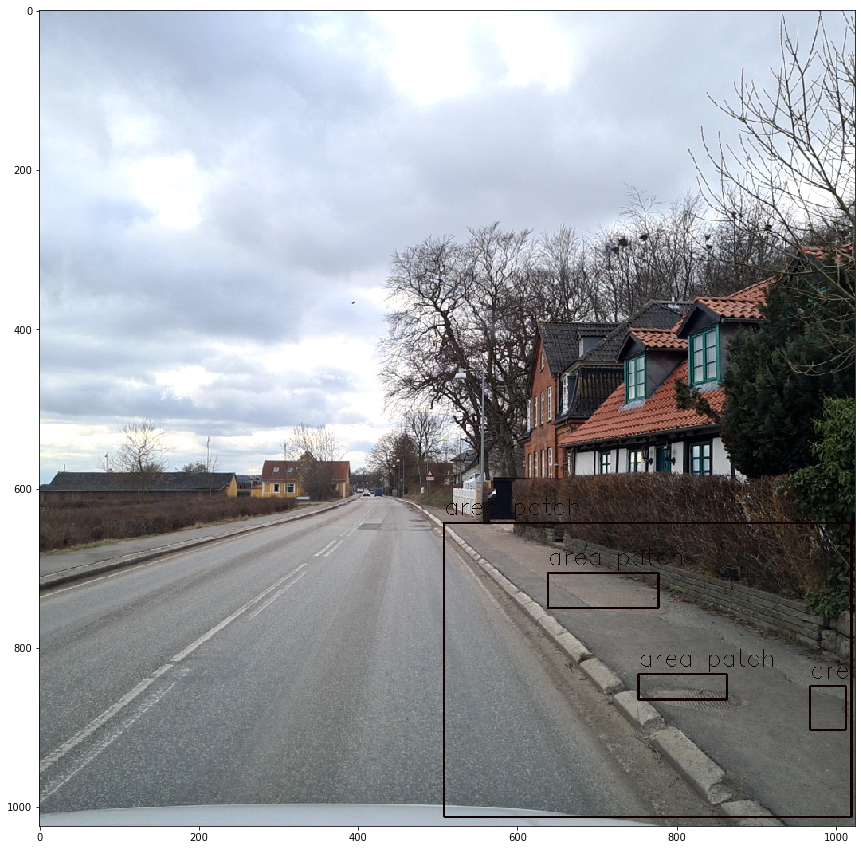

In [11]:
i = 15
one_frame = get_img(file_path[i])
frame_boxes_df = model_output[model_output["frame"] == i]
output_img = one_frame.copy()
for i, row in frame_boxes_df.iterrows():
    x1 = float(row.bb_left) - 1
    y1 = float(row.bb_top) - 1
    x2 = float(row.bb_width) - 1 + x1
    y2 = float(row.bb_height) - 1 + y1
    draw_bounding(output_img, int(x1), int(x2), int(y1), int(y2), row.label, row.label_index)
print_img(output_img)

In [88]:
from torchvision.transforms import ToTensor
one_frame
frame = {}
img = ToTensor()(Image.open(file_path[i]).convert("RGB")).reshape((1, 3, 1024, 1024))
print(img.shape)
frame['img'] = img

torch.Size([1, 3, 1024, 1024])


In [89]:
tracker.step(frame, 10)

In [90]:
results = tracker.get_results()

In [91]:
results

{0: {0: array([3.64582794e+02, 7.14370300e+02, 4.01690308e+02, 7.41017029e+02,
         1.00000000e+01, 5.90719819e-01])}}

In [8]:
fourcc = cv2.VideoWriter_fourcc(*"MJPG")
writer = cv2.VideoWriter("tracktor_video.avi", fourcc, 30, (1024, 1024), True)
for i in tqdm(range(len(model_output['frame'].unique()))):
    one_frame = get_img(file_path[i])
    frame_boxes_df = model_output[model_output["frame"] == i+1]
    output_img = one_frame.copy()
    for _, row in frame_boxes_df.iterrows():
        x1 = float(row.bb_left) - 1
        y1 = float(row.bb_top) - 1
        x2 = float(row.bb_width) - 1 + x1
        y2 = float(row.bb_height) - 1 + y1
        draw_bounding(
            output_img,
            int(x1), int(x2), int(y1), int(y2),
            f"[{row.id}] {row.label} - {round(row.confidence*100)}%]",
            color=255
        )
    writer.write(output_img)
writer.release()


In [9]:
frame_boxes_df

,frame,id,bb_left,bb_top,bb_width,bb_height,confidence,x,y,z,label_index,label
554,100,33,660.984802,938.329224,147.824097,87.039795,0.001188,-1,-1,-1,16,area patch
586,100,34,660.919373,938.525391,147.744690,86.998901,0.001174,-1,-1,-1,16,area patch
630,100,37,658.244202,939.851379,150.577026,86.148621,0.001087,-1,-1,-1,16,area patch
691,100,48,659.696655,949.180969,159.815125,76.551270,0.001110,-1,-1,-1,16,area patch
751,100,65,554.046631,549.236633,28.200439,79.228333,0.005356,-1,-1,-1,16,area patch
788,100,75,303.354736,825.910461,121.110870,155.535461,0.000862,-1,-1,-1,10,crack
